# About activity_descriptors_detector.ipynb

This notebook detects different aspects of activities from log files.

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
from tabulate import tabulate
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10,6
pd.options.mode.chained_assignment = None #removed annoying pandas warning when making chained assigment

# Getting log data

In [3]:
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

The file Sarah_beers_log_files_per_student.txt has been unpickled and loaded
The file Sarah_capacitor_log_files_per_student.txt has been unpickled and loaded


In [4]:
students = log_files_per_sim['beers'].keys()

# Aggregate pause detector

In [1]:
def detect_aggregate_action(log_files_per_sim,students,get_use_function):
    '''
    This function is a detector for a specific action that aggregates the findings over all students.
    
    Args:
        students (list): All student to run detector on
        log_files_per_sim (dict): dictionary by sim and student of log file names
        get_use_function (function): takes a dataframe and returns what it detected

    Returns:
        aggregate_action_use (dict): a dictionary by sim by student of aggregate use of action
    '''
    aggregate_action_use = {'beers':{sid:[] for sid in students},'capacitor':{sid:[] for sid in students}}
    
    for sim in ['beers','capacitor']:
        for sid in students:
            logs = log_files_per_sim[sim][sid]
            use = []

            for log in logs:
                df = prep_parsing_data(log,remove_model_events=False)
                if not df.empty:
                    use.extend(get_use_function(df))
#                     try:
#                         use.extend(get_use_function(df))
#                     except:
#                         print "Unable to run aggregate detector on sim =",sim,", sid =",sid
            aggregate_action_use[sim][sid] = use
    
    return aggregate_action_use

def get_time_between_actions(df):
    df = df[df['User or Model']=='user'] #remove model events, keep only user events
    df['previous Time'] = df['Time'].shift()
    df['time difference'] = df['Time'] - df['Time'].shift()
    df = df.iloc[1:] #removes first row with NaN time difference
    return df[(df['Event']!='dragged')&(df['Event']!='dragEnded')]['time difference']

In [6]:
all_intervals = detect_aggregate_action(log_files_per_sim,students,get_time_between_actions)

# Analysis
## Grab pauses

In [7]:
import itertools
intervals = list(itertools.chain.from_iterable(all_intervals['beers'].values()+all_intervals['capacitor'].values()))

In [9]:
max_pauses = []
for student,beer_pauses in all_intervals['beers'].iteritems():
    second_longuest_beers = sorted(beer_pauses)[-2]
    second_longuest_caps = sorted(all_intervals['capacitor'][student])[-2]
    max_pauses.append(max(second_longuest_beers,second_longuest_caps))

## Distribution of pauses

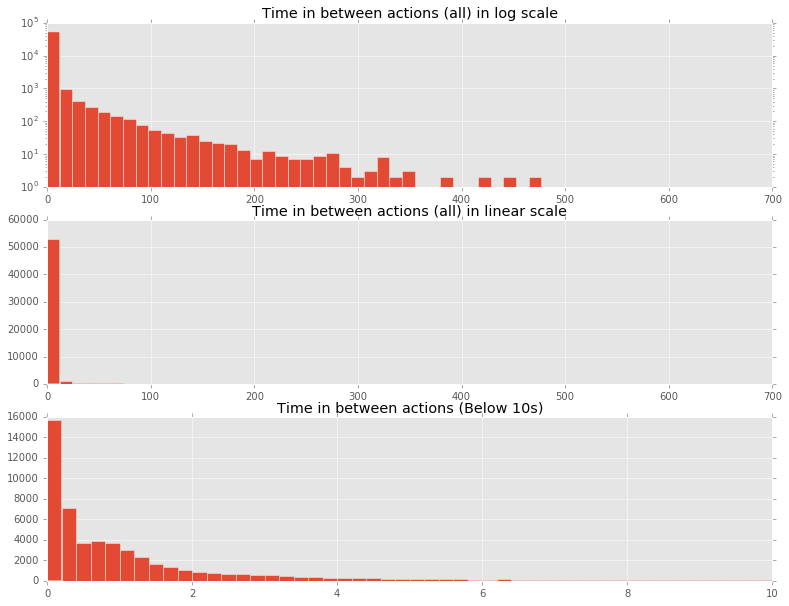

In [10]:
fig, axes = plt.subplots(3,figsize=(13,10))
a_cutoff,b_cutoff = 10,15
axes[0].hist(intervals, bins=50)
axes[0].set_title('Time in between actions (all) in log scale');axes[0].set_yscale('log')
axes[1].hist(intervals, bins=50)
axes[1].set_title('Time in between actions (all) in linear scale');axes[0]
axes[2].hist([i for i in intervals if i<a_cutoff], bins=50)
axes[2].set_title('Time in between actions (Below '+str(a_cutoff)+"s)")

## Second longest pauses

In [11]:
max_pauses = []
for student,beer_pauses in all_intervals['beers'].iteritems():
    second_longuest_beers = sorted(beer_pauses)[-2] # second max pause since max might be at the end of their activity until they close the window
    second_longuest_caps = sorted(all_intervals['capacitor'][student])[-2]
    max_pauses.append(max(second_longuest_beers,second_longuest_caps))

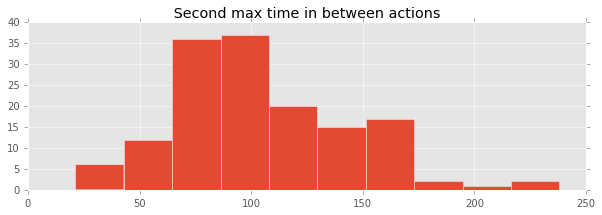

In [12]:
fig, ax = plt.subplots(1,figsize=(10,3))
ax.hist(max_pauses)
ax.set_title(' Second max time in between actions ');

In [13]:
np.mean(max_pauses),min(max_pauses),max(max_pauses),np.median(max_pauses)

(104.66205405405405, 21.31699999999995, 238.10400000000016, 94.58899999999997)

## Number of pauses per threshold

In [14]:
thresholds = [0.2,0.4,0.6,0.8]
thresholds.extend(range(1,25))
means_beers = []
means_caps = []
means_all = []
stds_beers = []
stds_caps = []
stds_all = []

for threshold in thresholds:
    pauses_beers = []
    pauses_caps = []
    pauses_all = []
    for student,student_beer_pauses in all_intervals['beers'].iteritems():
        pauses_beers.append(len([pause for pause in student_beer_pauses if pause>=threshold]))
        pauses_caps.append(len([pause for pause in all_intervals['capacitor'][student] if pause>=threshold]))
        pauses_all.append(pauses_beers[-1]) 
        pauses_all.append(pauses_caps[-1]) 
    means_beers.append(np.mean(pauses_beers))
    means_caps.append(np.mean(pauses_caps))
    means_all.append(np.mean(pauses_all))
    stds_beers.append(np.std(pauses_beers))
    stds_caps.append(np.std(pauses_caps))
    stds_all.append(np.std(pauses_all))

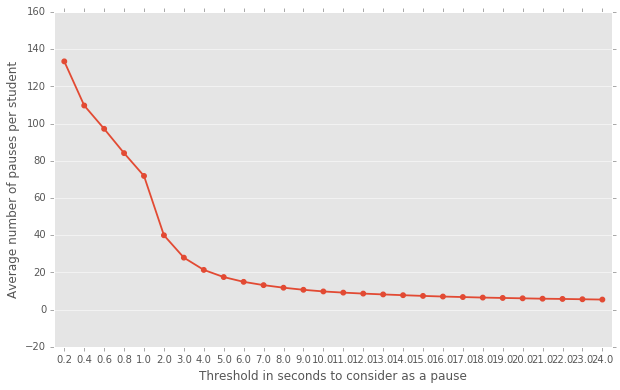

In [15]:
ax = sns.pointplot(x=thresholds, y=means_all,error=stds_all)
# ax.errorbar([t-1 for t in thresholds], means_all, yerr=stds_all,linewidth=1,linestyle='')
# ax.set_ylim((0,110))
ax.set_ylabel('Average number of pauses per student')
ax.set_xlabel('Threshold in seconds to consider as a pause')

In [16]:
import tabulate
table = [['Threshold (s)','Mean number pauses','Diff with previous threshold','ratio']]
diff = [m2-m1 for m1,m2 in zip(means_all[1:],means_all)]
ratio = [m2/m1 for m1,m2 in zip(means_all[1:],means_all)]
for a,b,c,d in zip(thresholds,means_all,diff,ratio):
    table.append([a,round(b,2),round(c,2),round(d,2)])
print tabulate.tabulate(table)

-------------  ------------------  ----------------------------  -----
Threshold (s)  Mean number pauses  Diff with previous threshold  ratio
0.2            133.45              23.72                         1.22
0.4            109.73              12.53                         1.13
0.6            97.2                13.07                         1.16
0.8            84.13               12.27                         1.17
1              71.86               31.9                          1.8
2              39.96               12.02                         1.43
3              27.94               6.59                          1.31
4              21.34               3.85                          1.22
5              17.49               2.57                          1.17
6              14.93               1.77                          1.13
7              13.15               1.38                          1.12
8              11.77               1.12                          1.1
9              10.65

# Descriptives

## Pick threshold

In [17]:
threshold = 9

In [18]:
nb_pauses_beers = []
nb_pauses_caps = []
nb_pauses_all = []
for student,student_beer_pauses in all_intervals['beers'].iteritems():
    nb_pauses_beers.append(len([pause for pause in student_beer_pauses if pause>=threshold]))
    nb_pauses_caps.append(len([pause for pause in all_intervals['capacitor'][student] if pause>=threshold]))
    nb_pauses_all.append(nb_pauses_beers[-1]) 
    nb_pauses_all.append(nb_pauses_caps[-1]) 

(0, 45)

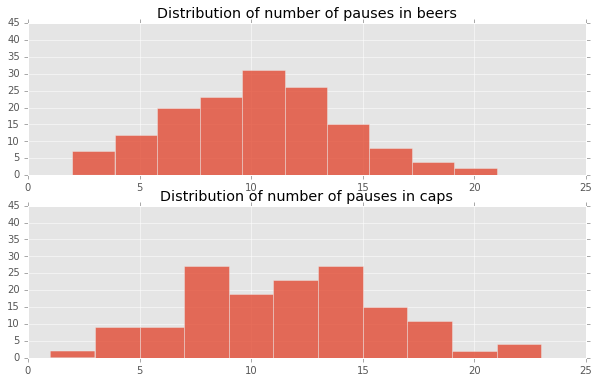

In [19]:
fig, axes = plt.subplots(2,figsize=(10,6))
axes[0].hist(nb_pauses_beers,alpha=0.8,bins=10)
axes[0].set_title('Distribution of number of pauses in beers');axes[0].set_ylim([0,45])
axes[1].hist(nb_pauses_caps,alpha=0.8,bins=11)
axes[1].set_title('Distribution of number of pauses in caps');axes[1].set_ylim([0,45])


## Pull external data

In [20]:
df = pd.read_csv("C:\\Users\\Sarah\\Documents\\Personal Content\\Lab_study_data\\all_massaged_data\\dataframe_all_factors_for_analysis.txt",sep = '\t')

In [21]:
def get_number_pauses(row,threshold):
    if row['sim']=='L':
        return len([pause for pause in all_intervals['beers'][row['sid']] if pause >= threshold])
    else:
        return len([pause for pause in all_intervals['capacitor'][row['sid']] if pause >= threshold])

In [22]:
df['nb_pauses_9'] = df.apply(lambda row: get_number_pauses(row,9),axis=1)

## Difference first and second sim

(0, 70)

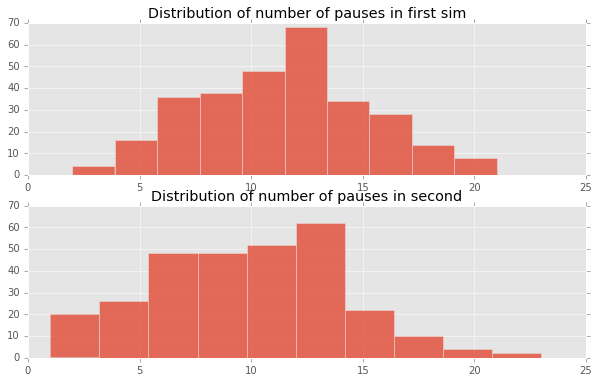

In [27]:
fig, axes = plt.subplots(2,figsize=(10,6))
axes[0].hist(df[df['sim_index']==1]['nb_pauses_9'],alpha=0.8,bins=10)
axes[0].set_title('Distribution of number of pauses in first sim');axes[0].set_ylim([0,70])
axes[1].hist(df[df['sim_index']==2]['nb_pauses_9'],alpha=0.8,bins=10)
axes[1].set_title('Distribution of number of pauses in second');axes[1].set_ylim([0,70])

We remove rows for two variables so we can do some stats and not count all students twice

In [28]:
df_fixed = df[df['variable'].isin(['Concentration','Separation'])]

In [32]:
import scipy
print scipy.stats.ttest_ind(df_fixed[df_fixed['sim_index']==1]['nb_pauses_9'],df_fixed[df_fixed['sim_index']==2]['nb_pauses_9'])
print scipy.stats.mannwhitneyu(df_fixed[df_fixed['sim_index']==1]['nb_pauses_9'],df_fixed[df_fixed['sim_index']==2]['nb_pauses_9'])

Ttest_indResult(statistic=3.4667866434775574, pvalue=0.00060589755260463945)
MannwhitneyuResult(statistic=8334.0, pvalue=0.00033991475479848432)


Students pause less in the second simulation! Hm.... Maybe they make better plans? Or have more efficient pauses? Or need less pauses in their exploration of the interface?

Let's check for other thresholds.

In [33]:
import math
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [34]:
table = [['Threshold (s)','t-test score','p-value','effect size']]
for t in [5,7,9,11,13,15,17]:
    df['nb_pauses_'+str(t)] = df.apply(lambda row: get_number_pauses(row,t),axis=1)
    df_fixed = df[df['variable'].isin(['Concentration','Separation'])]
    ss,pp = scipy.stats.ttest_ind(df_fixed[df_fixed['sim_index']==1]['nb_pauses_'+str(t)],df_fixed[df_fixed['sim_index']==2]['nb_pauses_'+str(t)])
    dd = cohend(df_fixed[df_fixed['sim_index']==1]['nb_pauses_'+str(t)],df_fixed[df_fixed['sim_index']==2]['nb_pauses_'+str(t)])
    table.append([t,ss,pp,dd])
print tabulate.tabulate(table)

-------------  -------------  -----------------  --------------
Threshold (s)  t-test score   p-value            effect size
5              4.33690508811  1.99216188534e-05  0.505866882321
7              4.07174907152  6.01442024061e-05  0.474938456471
9              3.46678664348  0.000605897552605  0.404374205886
11             3.62483028402  0.000341024942002  0.422808790478
13             3.52596491791  0.000489752119809  0.411276899993
15             3.73232839249  0.000227999395492  0.435347624481
17             3.68068316959  0.000276980005958  0.42932360335
-------------  -------------  -----------------  --------------


## Applied learning and pauses

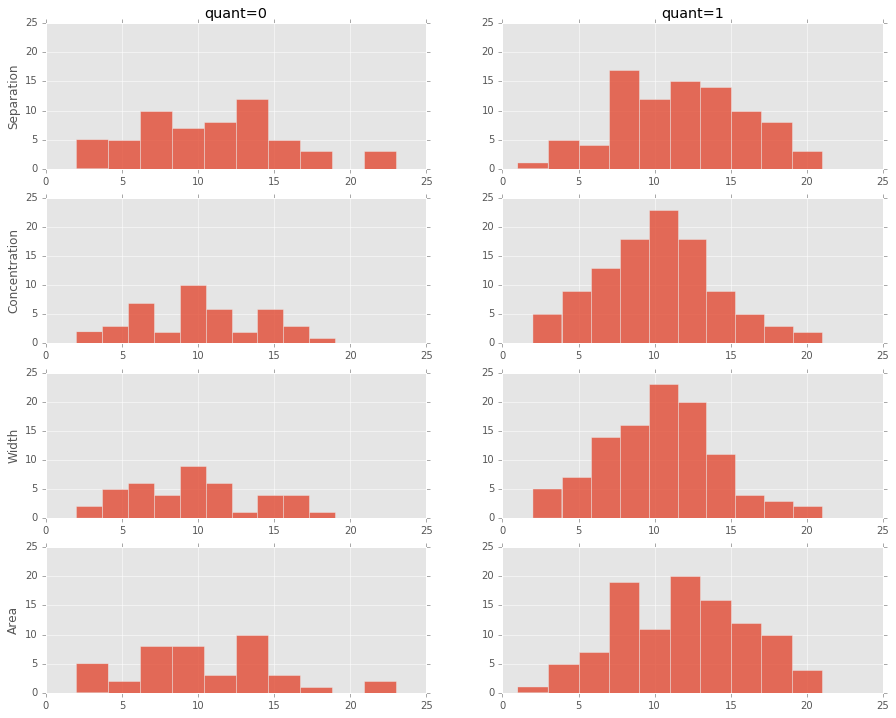

In [35]:
variables = ['Separation','Concentration','Width','Area']

fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(15,12))
for i,var in enumerate(variables):
    for j,score in enumerate([0,1]):
        ax=axes[i,j]
        df_per_var = df[df['variable']==var]
        ax.hist(df_per_var[df_per_var['quant_score']==score]['nb_pauses_9'],alpha=0.8,bins=10)
        if i==0:
            ax.set(title='quant='+str(score))
        if j==0:
            ax.set(ylabel=var)
        else:
            ax.set(ylabel='')
#         if i<2:
#             ax.set(xticklabels = [])
#         if i==2:
#             ax.set(xlabel='Percent of students')
        ax.set_ylim([0,25]);
        ax.set_xlim([0,25]);

In [36]:
variables = ['Separation','Concentration','Width','Area']
for i,var in enumerate(variables):
    df_per_var = df[df['variable']==var]
    print var, scipy.stats.mannwhitneyu(df_per_var[df_per_var['quant_score']==1]['nb_pauses_9'],df_per_var[df_per_var['quant_score']==0]['nb_pauses_9'])

Separation MannwhitneyuResult(statistic=2472.0, pvalue=0.33317580149796033)
Concentration MannwhitneyuResult(statistic=2199.0, pvalue=0.490564983501035)
Width MannwhitneyuResult(statistic=1991.0, pvalue=0.17927313595398303)
Area MannwhitneyuResult(statistic=1967.5, pvalue=0.15411641385596747)


## Model construction and pauses

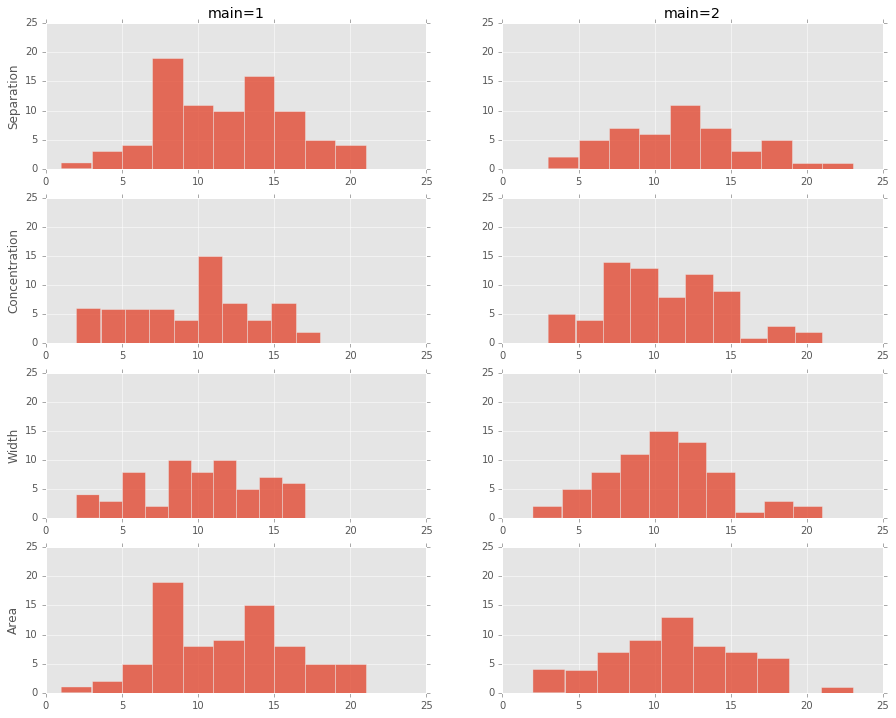

In [37]:
variables = ['Separation','Concentration','Width','Area']

fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(15,12))
for i,var in enumerate(variables):
    for j,score in enumerate([1,2]):
        ax=axes[i,j]
        df_per_var = df[df['variable']==var]
        ax.hist(df_per_var[df_per_var['main']==score]['nb_pauses_9'],alpha=0.8,bins=10)
        if i==0:
            ax.set(title='main='+str(score))
        if j==0:
            ax.set(ylabel=var)
        else:
            ax.set(ylabel='')
#         if i<2:
#             ax.set(xticklabels = [])
#         if i==2:
#             ax.set(xlabel='Percent of students')
        ax.set_ylim([0,25]);
        ax.set_xlim([0,25]);

In [38]:
variables = ['Separation','Concentration','Width','Area']
for i,var in enumerate(variables):
    df_per_var = df[df['variable']==var]
    print var, scipy.stats.mannwhitneyu(df_per_var[df_per_var['main']==1]['nb_pauses_9'],df_per_var[df_per_var['main']==2]['nb_pauses_9'])

Separation MannwhitneyuResult(statistic=1985.5, pvalue=0.48853373394614558)
Concentration MannwhitneyuResult(statistic=1962.0, pvalue=0.11022690815547709)
Width MannwhitneyuResult(statistic=1996.5, pvalue=0.25138790559356639)
Area MannwhitneyuResult(statistic=2267.0, pvalue=0.49297346340209047)


# Other analyses to do
* before vs. after 2nd record
* ???

# TOdo
*  make the function *get_parsed_log_files_per_student_for_sim(sim)* return logs sorted by date

In [39]:
df.head()

,sid,sim,variable,pre,main,cvs_graph,cvs_table,cvs_table_only,cvs_graph_inverse,cvs_graph_axes,...,use_table_beers,use_table_capacitor,use_graph_capacitor,nb_pauses_9,nb_pauses_5,nb_pauses_7,nb_pauses_11,nb_pauses_13,nb_pauses_15,nb_pauses_17
0,10127163,L,Concentration,0.0,2.0,1,1,0,0,1,...,1,1,1,10,17,13,9,9,9,9
1,10127163,L,Width,0.0,2.0,1,1,0,0,1,...,1,1,1,10,17,13,9,9,9,9
2,10127163,C,Area,2.0,2.0,1,1,0,0,1,...,1,1,1,14,22,18,11,11,10,9
3,10127163,C,Separation,2.0,2.0,1,1,0,1,2,...,1,1,1,14,22,18,11,11,10,9
4,10232160,L,Concentration,0.0,0.0,1,1,0,1,2,...,1,1,1,12,23,18,11,9,6,5
